In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
from pathlib import Path

In [3]:
from deeprte.model.rte import RTEOperator
from deeprte.model.config import model_config

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model_cfg = model_config()
solution_config = model_cfg.rte_operator

data_path = "/workspaces/deeprte/ckpts/train_delta_2022-08-24T17:05:33/models/latest/step_37500_2022-08-24T18:42:32/params.npz"

In [5]:
solution_config

activation: gelu
green_function:
  coefficient_net:
    attention_net:
      widths:
      - 64
      - 1
    pointwise_mlp:
      widths:
      - 64
      - 2
  green_function_mlp:
    widths:
    - 128
    - 128
    - 128
    - 128
    - 1

In [6]:
from deeprte.model.data import flat_params_to_haiku

params = np.load(data_path)
params_dict = flat_params_to_haiku(params)


In [7]:
from deeprte.model.modules import FunctionInputs
from deeprte.utils import flat_dict_to_rte_data
from collections.abc import Mapping
from deeprte.model.geometry.phase_space import PhaseSpace
from deeprte.dataset import _load_and_split_dataset, Split, process_inputs

def construct_input(data, grid):
    _grid, _ = preprocess_grid(grid)

    sigma = np.stack([data["sigma_t"], data["sigma_a"]], axis=-1)
    psi_bc = data["psi_bc"]
    psi_label = data["psi_label"]

    r, rv = _grid["r"], _grid["rv"]
    rv_prime, w_prime = _grid["rv_prime"], _grid["w_prime"]
    rv_r, rv_v = np.split(rv, 2, axis=-1)

    print(psi_bc.dtype)

    # print(psi_bc.shape, w_prime.shape)
    return r, {
        "inputs": (
            rv_r,
            rv_v,
            FunctionInputs(x=r, f=sigma),
            FunctionInputs(x=rv_prime, f=psi_bc * w_prime),
        ),
        "labels": psi_label,
    }

def preprocess_grid(
    grid: Mapping[str, np.ndarray], is_training: bool = True
) -> Mapping[str, np.ndarray]:
    _grid = dict(**grid)
    r, v = _grid["r"], _grid["v"]
    r = r.reshape(-1, r.shape[-1])
    _grid["r"] = r

    # rv = np.concatenate((r[:, None] + 0.0 * v, v + 0.0 * r[:, None]), axis=-1)
    rv = PhaseSpace(
        position_coords=r,
        velocity_coords=v,
        position_weights=0.0,
        velocity_weights=0.0,
    ).single_state(cartesian_product=True)
    rv = rv.reshape(-1, rv.shape[-1])
    _grid["rv"] = rv
    total_grid_size = rv.shape[0]

    rv_prime, w_prime = _grid["rv_prime"], _grid["w_prime"]
    _grid["rv_prime"] = rv_prime.reshape(-1, rv_prime.shape[-1])
    _grid["w_prime"] = w_prime.flatten()

    if is_training:
        del _grid["w_angle"], _grid["v"]

    return _grid, total_grid_size
    

In [8]:
datapath = "/workspaces/deeprte/data/train/train_delta.npz"
dataset = np.load(datapath, allow_pickle=False)

rte_data = flat_dict_to_rte_data(dataset)

In [9]:
data, grid = rte_data["data"], rte_data["grid"]
print(tf.nest.map_structure(lambda x: x.shape, data))
psi_shape = data['psi_label'].shape[1:]

{'sigma_t': (2000, 40, 40), 'sigma_a': (2000, 40, 40), 'psi_label': (2000, 40, 40, 24), 'phi': (2000, 40, 40), 'psi_bc': (2000, 160, 12)}


In [10]:
batch_size = 1
idx = 139
# _grid, _ = preprocess_grid(grid) 
_data = tf.nest.map_structure(
        lambda x: x[idx],
        data)
_data = tf.nest.map_structure(
        lambda x: np.reshape(x, [batch_size, -1]),
        _data)

# inputs = _construct_batch(_data, _grid)
# inputs = tf.nest.map_structure(lambda x: x.numpy() if isinstance(x, tf.Tensor) else x, inputs)
r, inputs = construct_input(_data, grid)
rv_r, v, sigma, psi_bc = inputs["inputs"]

float32


In [11]:
tf.nest.map_structure(lambda x: x.shape, _data)

{'sigma_t': (1, 1600),
 'sigma_a': (1, 1600),
 'psi_label': (1, 38400),
 'phi': (1, 1600),
 'psi_bc': (1, 1920)}

In [12]:
rte_sol = RTEOperator(config=solution_config)

In [31]:
out = rte_sol.apply(params_dict, None, 0, *inputs["inputs"], is_training=False)
output = out[0].reshape((batch_size, *psi_shape))

In [32]:
output.shape

(1, 40, 40, 24)

In [33]:
data["psi_label"].shape

(2000, 40, 40, 24)

In [13]:
import haiku as hk
import functools
from deeprte.model.mapping import vmap
from collections.abc import Callable
from deeprte.model.integrate import quad
from typing import Optional

import jax.numpy as jnp

from deeprte.model import mapping

@jax.jit
def rho(
    params: hk.Params,
    rng: jnp.ndarray,
    r: jnp.ndarray,
    sigma: FunctionInputs,
    psi_bc: FunctionInputs,
    quadratures: tuple[jnp.ndarray, jnp.ndarray],
) -> jnp.ndarray:

    _apply = functools.partial(rte_sol.apply, params, None, rng, is_training=True)
    _rho_fn = quad(_apply, quadratures, argnum=1, has_aux=True)
    v_rho_fn = vmap(
        vmap(_rho_fn, shard_size=128, argnums={0}),
        argnums={1, 2},
        in_axes=(FunctionInputs(), FunctionInputs()),
    )

    _rho = v_rho_fn(r, sigma, psi_bc)

    return _rho

# def flip_ad(matrix):
#     return np.fliplr(np.fliplr(matrix).T)

In [14]:
r.shape

(1600, 2)

In [15]:
psi_bc[1].shape

(1, 1920)

In [16]:
_psi_bc = FunctionInputs(psi_bc[0], psi_bc[1] * 5)

In [38]:
phi = rho(params_dict, 0, r, sigma, _psi_bc, (grid['v'], grid['w_angle']))

In [41]:
r

array([[0.0125    , 0.0125    ],
       [0.0125    , 0.0375    ],
       [0.0125    , 0.06250001],
       ...,
       [0.9875001 , 0.93750006],
       [0.9875001 , 0.9625001 ],
       [0.9875001 , 0.9875001 ]], dtype=float32)

In [18]:
phi = rte_sol.rho(params_dict, 0, r, sigma, _psi_bc, (grid['v'], grid['w_angle']))

In [19]:
phi_pre = phi[0]
# phi[0].shape
phi_pre = phi_pre.reshape((40, 40))
phi_pre = phi_pre.T

In [20]:
# rho = (output @  grid['w_angle']).squeeze()
# rho.shape

In [21]:
phi_label = _data["phi"].reshape((40,40)) * 5
phi_label.shape

(40, 40)

In [22]:
print(np.sqrt(np.mean((phi_label - phi_pre)**2)/np.mean(phi_label**2)))
print(np.mean((phi_label - 0)**2))
print(np.max(phi_label), np.min(phi_label))
print(np.max(phi_pre), np.min(phi_label))

0.05293678
0.0031838769
0.25163937 0.0012104203
0.25663057 0.0012104203


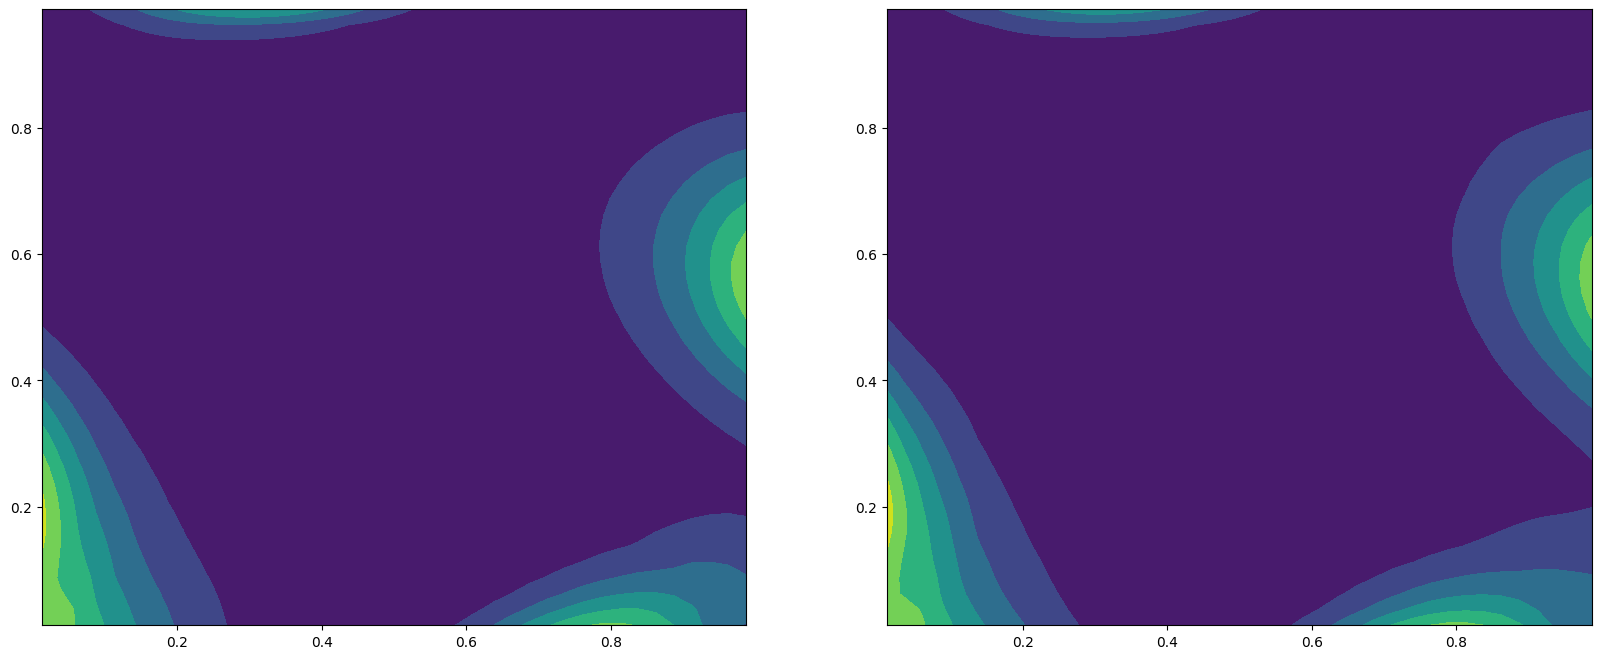

0.05293678


In [23]:
import matplotlib.pyplot as plt
import plotly.express as px

r = grid["r"]


fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

fig = px.density_contour(phi_label)
# fig.show()

cs_1 = axs[0].contourf(
    r[..., 0],
    r[..., 1],
    phi_label,
)
# axs[0].clabel(cs, inline=True, fontsize=10)
# fig.colorbar(cs, ax=axs[0])

# fig = px.density_contour(phi_pre)
cs_2 = axs[1].contourf(
    r[..., 0],
    r[..., 1],
    phi_pre,
)

plt.show()

print(np.sqrt(np.mean((phi_label - phi_pre)**2)/np.mean(phi_label**2)))

In [ ]:
psi_label = _data["psi_label"].squeeze()
psi_pre = out[0].squeeze()

In [ ]:
sum(abs(psi_label-psi_pre)**2)

DeviceArray(71.0001, dtype=float32)

In [ ]:
psi_label = _data["psi_label"].squeeze()
psi_label = psi_label.reshape((40,40,24))

In [ ]:
_phi = (psi_label @  grid['w_angle'])

In [ ]:
_phi.shape

(40, 40)

In [ ]:
print(np.sqrt(np.mean((_phi.T - phi_label)**2)/np.mean(phi_label**2)))

5.98825e-08
